### Library


In [9]:
import pandas as pd
import optuna
from optuna.samplers import TPESampler, GridSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.svm import SVR
import os
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Data Import 

In [10]:
X_train_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/X_train.csv"
y_train_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/y_train.csv"
X_test_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/X_test.csv"
y_test_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/y_test.csv"
df_train_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/df_train.csv"
df_test_path = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/df_test.csv"
X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path)
X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path)
df_train = pd.read_csv(df_train_path)
df_test = pd.read_csv(df_test_path)

### Optuna

In [11]:
rmses = []

def objective(trial):
        # 調整したいハイパーパラメータについて範囲を指定
        exponentC = trial.suggest_int("exponentC", -5, 10)
        exponentE = trial.suggest_int("exponentE", -10, 0)
        exponentG = trial.suggest_int("exponentG", -20, 10)
        paramC = ['linear', 'sigmoid', 'rbf', "poly"]
        param = {   'C': 2**exponentC,
                    'epsilon': 2**exponentE,
                    'gamma': 2**exponentG,
                    'kernel':trial.suggest_categorical('kernel', paramC),
                    'degree': trial.suggest_int('degree', 1, 3)
                }

        # KFoldのオブジェクトを作成
        kf = KFold(n_splits=folds, shuffle=True, random_state=42)

        #KFold CV
        for train_index, valid_index in kf.split(X_train):
                X_train_subset = X_train.loc[train_index]
                y_train_subset = y_train.loc[train_index]
                X_valid_subset = X_train.loc[valid_index]
                y_valid_subset = y_train.loc[valid_index]

                model_S = SVR(**param)
                model_S.fit(X_train_subset, y_train_subset)
                y_valid_pred = model_S.predict(X_valid_subset)

                # RMSEを算出
                temp_rmse_valid = np.sqrt(mean_squared_error(y_valid_subset, y_valid_pred))

                # RMSEをリストにappend
                rmses.append(temp_rmse_valid)

        # CVのRMSEの平均値を目的関数として返す
        return np.mean(rmses)

folds = 10
# search_space = {'exponentC':np.arange(-5, 11), 'exponentE':np.arange(-10, 1), \
#                 'exponentG':np.arange(-20, 11), 'kernel': ['linear', 'sigmoid', 'rbf']}
# study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space), direction='minimize')
# study.optimize(objective)

# # ベイズ最適化
sampler = TPESampler()
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=30)



print('Number of finalized trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

c = 2**study.best_trial.params['exponentC']
print('C:', c)
epsilon = 2**study.best_trial.params['exponentE']
print('epsilon:', epsilon)
gamma = 2**study.best_trial.params['exponentG']
print('gamma', gamma)
kernel = study.best_trial.params['kernel']
print('kernel', kernel)
df_param = pd.DataFrame({'C': [c],'epsilon': [epsilon], 'gamma': [gamma], 'kernel': [kernel]})
df_param.to_csv("/home/gakubu/デスクトップ/ML_git/MLT/ML_9/ML_9_3/param Ridge.csv", encoding='utf_8_sig', index=False)


[I 2023-12-13 16:30:46,495] A new study created in memory with name: no-name-b36eb1c3-2d31-4489-9a3b-c08b68a4d226
/home/gakubu/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/gakubu/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/gakubu/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/gakubu/.local/lib/python3.11/site-packages/sklearn/utils/validat

Number of finalized trials: 30
Best trial: {'exponentC': -3, 'exponentE': -10, 'exponentG': -2, 'kernel': 'linear', 'degree': 1}
C: 0.125
epsilon: 0.0009765625
gamma 0.25
kernel linear


### Create Model

In [12]:
model = SVR(C=c, epsilon=epsilon, gamma=gamma)
model.fit(X_train, y_train)

/home/gakubu/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=0.125, epsilon=0.0009765625, gamma=0.25)

In [13]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

### Evaluation

In [14]:
#各種評価指標をcsvファイルとして出力する
df_ee = pd.DataFrame({  'R^2(決定係数)': [r2_score(y_test, y_test_pred)],
                        'RMSE(二乗平均平方根誤差)': [np.sqrt(mean_squared_error(y_test, y_test_pred))],
                        'MSE(平均二乗誤差)': [mean_squared_error(y_test, y_test_pred)],
                        'MAE(平均絶対誤差)': [mean_absolute_error(y_test, y_test_pred)]})
df_ee.to_csv("/home/gakubu/デスクトップ/ML_git/MLT/ML_9/ML_9_4/Error Evaluation 9_4 SVR.csv",encoding='utf_8_sig', index=False)


In [15]:
# 図を作成するための準備
df_train['predict values'] = y_train_pred
df_train['residuals'] = df_train['predict values'] - df_train['RoI']
df_test['predict values'] = y_test_pred
df_test['residuals'] = df_test['predict values'] - df_test['RoI']


#df_trainに'legend'列を追加(凡例)
root_directory = "/home/gakubu/デスクトップ/ML_git/MLT/ML_9/"
for folder_name in os.listdir(root_directory):  
        for index,row in df_train.iterrows() :           #１行ずつ実行
                if folder_name + '_' in row['case_name']:                 #case_nameにfolder_nameが含まれているかどうか
                        df_train.loc[index,'legend'] = 'Training:' + folder_name

df_test['legend'] = 'Test data'

df_forfig = pd.concat([df_train, df_test])
# df_forfig.to_csv("/home/gakubu/デスクトップ/ML_git/MLT/ML_9/ML_9_4/df_forfig_SVR.csv"\
#                         ,encoding='utf_8_sig', index=False)

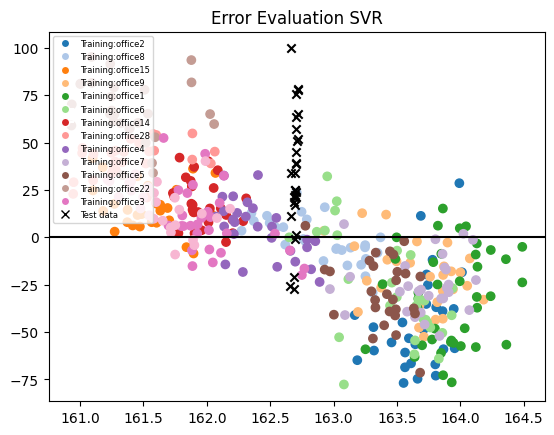

In [16]:
# 各オフィス名に対する色を 'tab20' カラーマップから取得
legend_names = df_train['legend'].unique()      #unique()メソッドは指定した列内の一意の値の配列を返す（重複を取り除く）
# print(legend_names)
colors = plt.cm.tab20(range(len(legend_names))) #tab20から配列legemd_namesの長さ分の色の配列colorsを返す
# 凡例名と色の対応を辞書に格納
# zip関数は２つ以上のリストを取り、それらの対応する要素をペアにしてイテレータを返す。
# この場合、legend_namesとcolorsの２つのリストをペアにし、対応する要素同士を取得する。
# =以降はofficeをキーとしてそれに対応するcolorが"値"として格納される辞書を作成
legend_color_mapping = {legend: color for legend, color in zip(legend_names, colors)}
# print(legend_color_mapping)
# 'legend' 列を数値（色情報に対応する数値）に変換
# 'legend_num'　を追加
df_train['legend_num'] = df_train['legend'].map(legend_color_mapping)
#散布図を作成
plt.scatter(df_train['predict values'], df_train['residuals'], c=df_train['legend_num'])
plt.scatter(df_test['predict values'], df_test['residuals'], c='black', marker='x' )
#y=0の直線を引く
# y = 0 の直線を描く
plt.axhline(y=0, color='black', linestyle='-')

# 凡例を作成
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, \
                        markersize=6, label=legend) for legend, color in zip(legend_names, colors)]
# Test dataの凡例を追加
handles[-1] = plt.Line2D([0], [0] ,marker='x', color='black', markersize=6, label='Test data', linestyle='None')

# 凡例を表示
plt.legend(handles=handles, loc='upper left', fontsize=6)


plt.title('Error Evaluation SVR')
plt.savefig("/home/gakubu/デスクトップ/ML_git/MLT/ML_9/ML_9_4/Error Evaluation (+test) SVR.pdf", format='pdf') 
# plt.show()